In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor,VotingRegressor,ExtraTreesRegressor, HistGradientBoostingRegressor,StackingRegressor
from sklearn.linear_model import Ridge,LinearRegression,SGDClassifier,SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report,mean_absolute_error,make_scorer
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm as lgb
from xgboost import XGBRegressor
import optuna 

# Loading dataset

In [16]:
train_data = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv") 
test_data = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")

Display all columns

In [17]:
train_data.columns

Index(['trafficSource.isTrueDirect', 'purchaseValue', 'browser',
       'device.screenResolution', 'trafficSource.adContent',
       'trafficSource.keyword', 'screenSize', 'geoCluster',
       'trafficSource.adwordsClickInfo.slot', 'device.mobileDeviceBranding',
       'device.mobileInputSelector', 'userId', 'trafficSource.campaign',
       'device.mobileDeviceMarketingName', 'geoNetwork.networkDomain',
       'gclIdPresent', 'device.operatingSystemVersion', 'sessionNumber',
       'device.flashVersion', 'geoNetwork.region', 'trafficSource',
       'totals.visits', 'geoNetwork.networkLocation', 'sessionId', 'os',
       'geoNetwork.subContinent', 'trafficSource.medium',
       'trafficSource.adwordsClickInfo.isVideoAd', 'browserMajor',
       'locationCountry', 'device.browserSize',
       'trafficSource.adwordsClickInfo.adNetworkType', 'socialEngagementType',
       'geoNetwork.city', 'trafficSource.adwordsClickInfo.page',
       'geoNetwork.metro', 'pageViews', 'locationZone',
      

Display all rows and columns

In [18]:
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",100)

Checking datatypes and null value counts

In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding                   11

In [19]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29006 entries, 0 to 29005
Data columns (total 51 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   userChannel                                   29006 non-null  object 
 1   date                                          29006 non-null  int64  
 2   browser                                       29006 non-null  object 
 3   device.browserSize                            29006 non-null  object 
 4   device.browserVersion                         29006 non-null  object 
 5   deviceType                                    29006 non-null  object 
 6   device.flashVersion                           29006 non-null  object 
 7   device.isMobile                               29006 non-null  bool   
 8   device.language                               29006 non-null  object 
 9   device.mobileDeviceBranding                   29006 non-null 

# Exploratory Data Analysis

In [ ]:
train_data.shape,test_data.shape

In [ ]:
train_data.head()

Numerical column description

In [ ]:
train_data.describe()

In [ ]:
train_data.info()

**About Columns**
1.  *trafficSource.isTrueDirect*: Whether a customer came directly to the site.
2.  *purchaseValue*: The amount spent by the customer during the session.Target variable.
3.  *browser*: Web browser used by the user during ths session.
4.  *device.screenResolution*: Screen resolution of the user's device. *
5.  *trafficSource.adContent*: Specific ad text clicked by the user. *
6.  *trafficSource.keyword*: For what item,user searched! *
7.  *screenSize*: Size of the user's device,used during session.
8.  *geoCluster*: Grouping based on geographic patterns.
9.  *trafficSource.adwordsClickInfo.slot*: Position on the search result page. *
10. *device.mobileDeviceBranding*: Which mobile brand is used! *
11. *device.mobileInputSelector*: Type of input device. *
12. *userId*: Unique identifier for user.
13. *trafficSource.campaign*: Name of the marketing compaign
14. *device.mobileDeviceMarketingName*: Official marketing name of mobile device model. *
15. *geoNetwork.networkDomain*: Network domain through the user was connected while visiting the website.
16. *gclIdPresent*: Presence of a Google Click ID used in ad tracking.
17. *device.operatingSystemVersion*: Version of Operating system. *
18. *sessionNumber*: In which session website is used.
19. *device.flashVersion*: Flash version during the visit. *
20. *geoNetwork.region*: Geographic region of the user. *
21. *trafficSource*: Specific source of traffic.
22. *totals.visits*: Number of visits in a given session.
23. *geoNetwork.networkLocation*: Name of the organization associated with visiters IP address. *
24. *sessionId*: Unique identifier of a session.
25. *os*: Operating System.
26. *geoNetwork.subContinent*: Subcontinental geographic region of the user.
27. *trafficSource.medium*: Type of traffic.
28. *trafficSource.adwordsClickInfo.isVideoAd*: Whether user clicked on video ad. *
29. *browserMajor*: Browser used. *
30. *locationCountry*: Country from where particular session is done.
31. *device.browserSize*: Dimension of browser used during the session. *
32. *trafficSource.adwordsClickInfo.adNetworkType*:
33. *socialEngagementType*: User involved in social media interaction.
34. *geoNetwork.city*: City from where website is accessed. *
35. *trafficSource.adwordsClickInfo.page*:
36. *geoNetwork.metro*: Region from where website is accessed.
37. *pageViews*: Number of pages viewed by user during the session.
38. *locationZone*: Marketing zone.
39. *device.mobileDeviceModel*:
40. *trafficSource.referralPath*: URL path from where the user was referred to the website.
41. *totals.bounces*: Number of times user visited only one page and then left.
42. *date*: Date of the session.
43. *device.language*:
44. *deviceType*: Type of the device used.
45. *userChannel*: Channel through which the user interacted with the platform.
46. *device.browserVersion*:
47. *totalHits*: Total number of hits by a single user.
48. *device.screenColors*:
49. *sessionStart*: Timestamp when the session begins.
50. *geoNetwork.continent*: Continent from where website is accessed.
51. *device.isMobile*: If website is accessed with mobile.
52. *new_visits*: If the user visits the website for the first time.


In [ ]:
train_data['trafficSource.isTrueDirect'].unique()

Insight - 
     * 42890 people come directly to the website

In [ ]:
train_data['purchaseValue'].unique()

In [ ]:
train_data['purchaseValue'].value_counts()

In [ ]:
train_data[train_data['purchaseValue']=='NaN'].shape

In [ ]:
train_data[train_data['purchaseValue']==0].shape

Insight - 
           Total 92038 people made no purchase.

In [ ]:
train_data['browser'].unique()

In [ ]:
train_data['screenSize'].unique()

Insight - 
            Medium screenSize is used for browsing. 

In [ ]:
train_data['geoCluster'].unique()

Insight - Total 5 geoCluster regions are there.

In [ ]:
train_data['userId'].unique()

In [ ]:
train_data['userId'].value_counts()

In [ ]:
train_data[train_data['userId']=='NaN'].shape

Insight - 
       Every user has userId.But every userId is not unique.

In [ ]:
train_data['trafficSource.campaign'].unique().shape

Insight - 
          Total 28 unique marketing compaign.

In [ ]:
train_data['geoNetwork.networkDomain'].unique()

In [ ]:
train_data['gclIdPresent'].unique()

In [ ]:
train_data[train_data['gclIdPresent']==1].shape

Insight - 4295 people arrived from the paid advertisement.

In [ ]:
train_data['sessionNumber'].unique()

In [ ]:
train_data['sessionNumber'].value_counts().sum()

In [ ]:
train_data['trafficSource'].unique().shape

In [ ]:
train_data['trafficSource'].isna().sum()

Insight - 161 different souces are used by different users.

In [ ]:
train_data['totals.visits'].value_counts()

Insight - Every user visited website once in each session.

In [ ]:
train_data['os'].unique().shape

Insight - 18 different os are used for browsing.

In [ ]:
train_data['geoNetwork.subContinent'].unique().shape


Insight - Browsing is done from 23 differnt geographic regions

In [ ]:
train_data['trafficSource.medium'].unique()


Insight - From which source people attracted towards website.

In [ ]:
train_data['locationCountry'].unique()

In [ ]:
train_data['locationCountry'].value_counts()

Insight - Mostly people who used website are from United States.

In [ ]:
train_data['socialEngagementType'].unique().shape


In [ ]:
train_data['socialEngagementType'].value_counts()

Insight - Every user is not socially enagaged.

In [ ]:
train_data['geoNetwork.metro'].unique().shape

In [ ]:
train_data['geoNetwork.metro'].value_counts()

Insight - Most of the user's data is either not available or (not set).

In [ ]:
train_data['pageViews'].value_counts()

Insight - 47372 people left website after visiting first page.

In [ ]:
train_data['locationZone'].value_counts()

In [ ]:
train_data['trafficSource.referralPath'].unique().shape

In [ ]:
train_data['trafficSource.referralPath'].value_counts()


In [ ]:
train_data['trafficSource.referralPath'].isna().sum()

Insight - For about 73309 users referralPath is not given.

In [ ]:
train_data['totals.bounces'].unique()

In [ ]:
train_data['totals.bounces'].value_counts()

Insight - 47148 people left after visiting the first page of website.

In [ ]:
train_data['deviceType'].unique()

In [ ]:
train_data['deviceType'].value_counts()

Insight - 
           desktop  -  86480
            mobile  -  25850
           tablet   -  3693

In [ ]:
train_data['userChannel'].unique()

In [ ]:
train_data['userChannel'].value_counts()

In [ ]:
train_data['totalHits'].value_counts()

Insight - Number of times user hits website.

In [ ]:
train_data['sessionStart'].value_counts()

In [ ]:
train_data[train_data['sessionStart']=='NaN'].shape

In [ ]:
train_data['geoNetwork.continent'].unique()

In [ ]:
train_data['geoNetwork.continent'].value_counts()

In [ ]:
train_data['device.isMobile'].unique()

In [ ]:
train_data['device.isMobile'].value_counts()

In [ ]:
train_data['new_visits'].unique()

In [ ]:
train_data['new_visits'].value_counts()

In [ ]:
#if 'date' in train_data.columns:
    #train_data['date'] = pd.to_datetime(train_data['date'], format='%Y%m%d', errors='coerce')

In [ ]:
duplicate_count = train_data.duplicated().sum()
duplicate_count,train_data.duplicated().describe()

In [6]:
df = train_data.copy(deep=True)
df.shape

(116023, 52)

In [7]:
df = train_data.dropna(how='all')
df = df.dropna(axis=1,how='all')
df = df.drop_duplicates()
print(f"Remaining shape:{df.shape}")

Remaining shape:(115787, 52)


In [8]:
num_cols = df.select_dtypes(include=['number']).columns
print(num_cols.shape)
num_cols

(14,)


Index(['purchaseValue', 'userId', 'gclIdPresent', 'sessionNumber',
       'totals.visits', 'sessionId', 'trafficSource.adwordsClickInfo.page',
       'pageViews', 'locationZone', 'totals.bounces', 'date', 'totalHits',
       'sessionStart', 'new_visits'],
      dtype='object')

In [9]:
cat_cols = df.select_dtypes(exclude=['number']).columns
print(cat_cols.shape)
cat_cols

(38,)


Index(['trafficSource.isTrueDirect', 'browser', 'device.screenResolution',
       'trafficSource.adContent', 'trafficSource.keyword', 'screenSize',
       'geoCluster', 'trafficSource.adwordsClickInfo.slot',
       'device.mobileDeviceBranding', 'device.mobileInputSelector',
       'trafficSource.campaign', 'device.mobileDeviceMarketingName',
       'geoNetwork.networkDomain', 'device.operatingSystemVersion',
       'device.flashVersion', 'geoNetwork.region', 'trafficSource',
       'geoNetwork.networkLocation', 'os', 'geoNetwork.subContinent',
       'trafficSource.medium', 'trafficSource.adwordsClickInfo.isVideoAd',
       'browserMajor', 'locationCountry', 'device.browserSize',
       'trafficSource.adwordsClickInfo.adNetworkType', 'socialEngagementType',
       'geoNetwork.city', 'geoNetwork.metro', 'device.mobileDeviceModel',
       'trafficSource.referralPath', 'device.language', 'deviceType',
       'userChannel', 'device.browserVersion', 'device.screenColors',
       'geoNetwor

In [10]:
df.replace('not available in demo dataset', np.nan, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.shape

/tmp/ipykernel_35/3881413182.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('not available in demo dataset', np.nan, inplace=True)


(115787, 39)

In [11]:
#Numeric correlation with purchseValue
num_cols = num_cols.drop('purchaseValse',errors='ignore')
correlations = df[num_cols].corrwith(df['purchaseValue']).sort_values(key=abs, ascending=False)
print(correlations)

purchaseValue                          1.000000
totalHits                              0.251095
pageViews                              0.247827
sessionNumber                          0.230761
trafficSource.adwordsClickInfo.page   -0.025661
sessionId                             -0.018314
sessionStart                          -0.018314
date                                  -0.010221
gclIdPresent                          -0.005675
userId                                -0.003501
totals.visits                               NaN
locationZone                                NaN
totals.bounces                              NaN
new_visits                                  NaN
dtype: float64


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Insight - 
     * totalHits and pageViews show strong Positive correlation with purchaseVlaue
     * sessionNumber  shows weak positive correlation
     * trafficSource.adwordsClickInfo.page, sessionId, and sessionStart have almost no correlation with purchase value
     * totals.visits, new_visits, and totals.bounces produce NaNs, which means these columns have constant values and need to be dropped

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


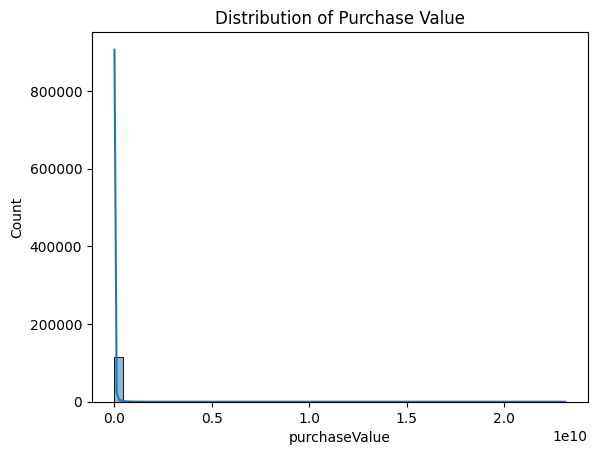

In [12]:
#Behaviour of Target Variable
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df['purchaseValue'], bins=50, kde=True)
plt.title('Distribution of Purchase Value')
plt.show()

Insight - 
 * target column is very right skewed.

In [13]:
skewness = df['purchaseValue'].skew()
print(skewness) #postive skewed

54.01703550987996


In [14]:
print(df.skew(axis=0,numeric_only=True))

purchaseValue                          54.017036
userId                                  0.002133
gclIdPresent                            4.906437
sessionNumber                          20.420319
totals.visits                           0.000000
sessionId                               0.371038
trafficSource.adwordsClickInfo.page    11.255540
pageViews                               5.789640
locationZone                            0.000000
totals.bounces                          0.000000
date                                    0.235728
totalHits                               5.604341
sessionStart                            0.371038
device.isMobile                         1.125983
new_visits                              0.000000
dtype: float64


Insight - 
  * high right skewed features -   "purchaseValue","sessionNumber", "trafficSource.adwordsClickInfo.page", "pageViews", "totalHits".
  * moderate right skewed features - "gclIdPresent", "device.isMobile".
  * symmetrical or low skewed features - "userId", "sessionId", "date", "totals.visits", "locationZone", "totals.bounces", "new_visits"

In [ ]:
#Log transformed target correlation with numerical columns 
df['log_purchaseValue'] = np.log1p(df['purchaseValue'])
correlations_log = df[num_cols].corrwith(df['log_purchaseValue']).sort_values(key=abs, ascending=False)
print("Correlation with Log-PurchaseValue (Numeric Features):")
print(correlations_log)


Insight - 
after log transformation of purchase value,
 shows strong positive correlation with pageViews, totalHits and moderate correlation with
 original skewed target.
 weak correlation with sessionNumber, trafficSource.adwordsClickInfo.page, sessionId,     sessionStart, date.
 no correlation with totals.visits, locationZone, totals.bounces, new_visits because these featues have either one unique value or nan value.

In [15]:
#Behaviour of log transformed Target Variable
sns.histplot(df['log_purchaseValue'], bins=50, kde=True)
plt.title('Log-Transformed Purchase Value')
plt.show()

KeyError: 'log_purchaseValue'

Insight - 
     The plot of "Log-Transformed Purchase Value" shows a bimodal distribution.

This means there are two distinct peaks:

# Milestone -1

In [ ]:
##Question-1
'''
df_non_bounce = df[df['totals.bounces'] != 1]
df_filtered = df_non_bounce[['pageViews', 'purchaseValue']].dropna()
correlation = df_filtered['pageViews'].corr(df_filtered['purchaseValue'])
print(f"Correlation between pageViews and purchaseValue (non-bounce users): {correlation:.4f}")
'''

In [ ]:
##Highest Average totalHits Continents
'''
avg_hits_by_continent = df.groupby('geoNetwork.continent')['totalHits'].mean()
highest_avg_continent = avg_hits_by_continent.idxmax()
highest_avg_value = avg_hits_by_continent.max()
print(f"Continent with highest average totalHits: {highest_avg_continent} ({highest_avg_value:.2f})"
'''

In [ ]:
##Common medium for purchasers
df['purchaseValue'] = pd.to_numeric(df['purchaseValue'], errors='coerce')
purchasers = df[df['purchaseValue'] > 0]
most_common_medium = purchasers['trafficSource.medium'].mode()[0]
print(f"The most common traffic source medium for purchasers is: {most_common_medium}")

In [ ]:
purchasers = df[df['purchaseValue'] > 0]
combo_counts = purchasers.groupby(['os', 'browser']).size()
#most_common_combo = combo_counts.idxmax()
most_common_count = combo_counts.max()
most_common_count

In [ ]:
purchase_sessions = df[df['purchaseValue'] > 0]
non_purchase_sessions = df[df['purchaseValue'] <= 0]
avg_hits_purchase = purchase_sessions['totalHits'].mean()
avg_hits_non_purchase = non_purchase_sessions['totalHits'].mean()
ratio = avg_hits_purchase / avg_hits_non_purchase if avg_hits_non_purchase else float('inf')
print(f"Average hits for purchase sessions: {avg_hits_purchase:.2f}")
print(f"Average hits for non-purchase sessions: {avg_hits_non_purchase:.2f}")
print(f"Ratio (purchase / non-purchase): {ratio:.2f}")

In [ ]:
organic_mask = df['trafficSource.medium'] == 'organic'
non_organic_mask = df['trafficSource.medium'] != 'organic'
organic_sessions = organic_mask.sum()
non_organic_sessions = non_organic_mask.sum()
total_sessions = len(df)

proportion_organic = organic_sessions / total_sessions
proportion_non_organic = non_organic_sessions / total_sessions

print(f"Proportion of organic sessions: {proportion_organic:.2%}")
print(f"Proportion of non-organic sessions: {proportion_non_organic:.2%}")

In [ ]:
df['purchaseValue'] = pd.to_numeric(df['purchaseValue'], errors='coerce')
# Filter sessions with purchase > 0
purchase_sessions = df[df['purchaseValue'] > 0]
# Most common referral path
most_common_referral_path = purchase_sessions['trafficSource.referralPath'].mode()[0]
print(f"Most common referral path among all purchasers: {most_common_referral_path}")

In [ ]:
# Groupby operating system and calculate mean
avg_purchase_by_os = df.groupby('os')['purchaseValue'].mean()

# Os with highest average purchasevalue
highest_avg_os = avg_purchase_by_os.idxmax()
highest_avg_value = avg_purchase_by_os.max()

print(f"Operating system with highest average purchase value: {highest_avg_os} ({highest_avg_value:.2f})")

In [ ]:
sessions_per_user = df.groupby('userId').size()
# Average
average_sessions = sessions_per_user.mean()
print(f"Average number of sessions per user: {average_sessions:.2f}")

In [ ]:
unique_users = df['userId'].nunique()
print(f"Number of unique users: {unique_users}")

# Some Visualizations

In [ ]:
#Checking outliers in target variable
sns.boxplot(df['purchaseValue'])

Insight - 
* Extreme amount of outliers are present.
* Strong right skewed distribution.


In [ ]:
print(df['purchaseValue'].value_counts(dropna=False))

Insight - 
* Majority values are 0 which means most of the users didn't make a purchase.
* Imbalance target

In [ ]:
print(df['new_visits'].value_counts(dropna=False))
print(df['new_visits'].unique())

In [ ]:
## New vs Old users
if 'new_visits' in df.columns and 'purchaseValue' in df.columns:
    sns.boxplot(x=df['new_visits'], y=df['purchaseValue'])
    plt.title("New vs Returning User Purchase Behavior")
    plt.show()

Insight - 
* Outliers are present.
* No data is given for returning users.

In [ ]:
##Checking trends for date vs purchaseValue
if 'date' in df.columns:
    df_time = df.groupby('date')['purchaseValue'].sum()
    df_time.plot(figsize=(20, 6), title="Total Purchase Over Time")
    plt.ylabel("Purchase Value")
    plt.show()

Insight - 
* Uneven distribution of purchases.Most of the time purchases are 0.
* Three different time periods when most of the purchases are made.This might be due to seasonal compaign.

In [ ]:
##Seperating day,weekday,month,year
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df.drop('date',axis=1,inplace=True)
print(df.shape[1])

In [ ]:
#Analyze purchaseVale by day
df.groupby('day')['purchaseValue'].mean().plot()

Insight - 
     * The count fluctuates considerably from day to day. There isn't a smooth trend.
     * Day 5 shows the highest count.
     * Day 5 and Day 14 being the most active days in terms of count.

In [ ]:
#Analyze purchaseValue by weekday
df.groupby('weekday')['purchaseValue'].mean().plot()

Insight - 
* Most sales happen on Wednesday which indicates on midweek most of the sales happen.
* Very less amount of sale on Saturday.
* Little recovery on Saturday.But very less as compared to weekdays.

In [ ]:
#Analyze purchaseValue by month
df.groupby('month')['purchaseValue'].mean().plot()

Insight - 
* Purchases have very high seasonal trend.
* April - August are high activity period.

In [ ]:
#Analyze purchaseValue by year
df.groupby('year')['purchaseValue'].mean().plot()

Insight - 
  * Yearly trend is seen.
  * 2017 was the year in which very large amount of sales were made. But in 2018,due to some reason sales drops sharply.

In [ ]:
#Identifying categorical columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols = [col for col in cat_cols if col in df.columns and df[col].nunique() < 100]
#Total categorical columns
print(len(cat_cols))

In [ ]:
for col in cat_cols[:10]:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().head(10).index)
    plt.xticks(rotation=45)
    plt.title(f"Top Categories in {col}")
    plt.show()

Insight - 
* trafficSource.isTrueDirect :
  * Only one category 'True' is seen.
  * More than 40,000 counts for 'True' category.
  * Indicates these many users came directly to the website.
* browser :
  * chrome holds dominant position with a count about 80,000
  * second most used browser is safari with a count about 20,000.
  * safari is third one with count about 5,000.
  * other browsers have very low count.
* trafficeSource.adContent :
  *  "Google Merchandise Store" is the most dominant ad content category.
  *   second most dominant is "Google Merchandise Collection"
  *   other ad content category have very low impact on sales.
* screensize :
  * only one unique screensize category 'Medium' is present which is used by approximately   116,000 users.
* geocluster :
  * Uniform Distribution among all Categories
* trafficSource.adwordsClickInfo.slot :
  * Top ad slot are most common, followed by RHS then Google Display Network have very negligible slot counts.
* trafficSource.compaign :
  * Mojority counts of (not set) suggest that most of the users arrive at the site is directly, making it challenging to evaluate the impact of specific advertising efforts from this  view.
* geoNetwork.NetworkDomain :
  * The top three network domains have same distribution which suggest traffic is relatively balanced across these top contributors
* os : Windows is the most common operating system, with nearly 40,000 counts, followed by Macintosh (around 37,000).
* geoNetwork.subContinent :
  * Most of the traffic is by North America.

In [ ]:
#Bar plot for top Comapign revenue
if 'trafficSource.campaign' in df.columns:
    top_campaigns = df['trafficSource.campaign'].value_counts().head(10).index
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df[df['trafficSource.campaign'].isin(top_campaigns)],
                  y='trafficSource.campaign', order=top_campaigns)
    plt.title("Top 10 Campaigns by Session Count")
    plt.tight_layout()
    plt.show()

    top_campaigns_by_revenue = df.groupby('trafficSource.campaign')['purchaseValue'].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_campaigns_by_revenue.values, y=top_campaigns_by_revenue.index)
    plt.title("Top 10 Campaigns by Total Purchase Value")
    plt.tight_layout()
    plt.show()


In [ ]:
for col in ['deviceType', 'geoNetwork.continent']:
    if col in df.columns:
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=df, x=col, y='purchaseValue')
        plt.xticks(rotation=45)
        plt.title(f'Purchase Value by {col}')
        plt.show()

Numerical Column Correlation

In [ ]:
num_df = df.select_dtypes(include='number')
corr_matrix = num_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Insight - 
   * Most variables have a very weak linear correlation with purchaseValue.

In [ ]:
#if 'browser' in df.columns:
    #3top_browsers = df['browser'].value_counts().nlargest(10).index
    #df['browser_reduced'] = df['browser'].where(df['browser'].isin(top_browsers), 'Other')

In [ ]:
sns.boxplot(x='weekday', y='purchaseValue', data=df)
plt.title('Purchase Value by Weekday')
plt.show()

sns.boxplot(x='month', y='purchaseValue', data=df)
plt.title('Purchase Value by Month')
plt.show()

Insight -  Weekday - extremely high-value purchases are  made during the weekdays while significant drop can be seen on weekends, month - April, September, and February made very high-value transactions, indicating good buying behaviors for significant purchases.

In [ ]:
##User
for col in ['deviceType','device.isMobile']:
    if col in df.columns:
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=col, y='purchaseValue', data=df)
        plt.xticks(rotation=45)
        plt.title(f'Purchase Value by {col}')
        plt.show()

Insight -  deviceType -  Most users across all device types are making small or no purchases. Users who made high - value transactions, uses dextop while doing so. Mobile and tablet users made lower high - value purchases. That suggest high - value transactions are less common to those devices. ,device.isMobile - High-value purchases mostly happen on computers (non-mobile devices). People rarely make very large purchases using their phones or tablets. Most purchases,regardless of device, are small.

In [ ]:
# Top categories for network domain
top_domains = df['geoNetwork.networkDomain'].value_counts().head(10).index
filtered = df[df['geoNetwork.networkDomain'].isin(top_domains)]

plt.figure(figsize=(12, 5))
sns.boxplot(x='geoNetwork.networkDomain', y='purchaseValue', data=filtered)
plt.xticks(rotation=45)
plt.title("Purchase Value for Top 10 Network Domains")
plt.show()

Insight - 
        * Skewed distributions with many outliers.
        * High value outliers are present.

In [ ]:
sns.heatmap(df[['totalHits', 'pageViews', 'purchaseValue']].corr(), annot=True)

Insight - 
   * High Correlation between totalHits and pageViews indicates an extremely strong positive linear relationship.
   * Not very strong relationship between (totalHits and purchaseValue) and (pageViews and purchaseValue).

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['pageViews'], y=df['purchaseValue'])
plt.title('Pageviews vs Purchase Value')
plt.xlabel('pageViews')
plt.ylabel('purchaseValue')
plt.grid(True)
plt.show()


Insight - As pageViews increase beyond 100, the purchaseValue does not consistently increase.Insight - High density near origin which indicates most users view only a few pages and generate small or no purchases. Few users with very less pageViews made very large purchases which indicates outliers. 

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['totalHits'], y=df['purchaseValue'])
plt.title('Hits vs Purchase Value')
plt.xlabel('totalHits')
plt.ylabel('purchaseValue')
plt.grid(True)
plt.show()

Insight -  Highly skewed and sparse target variable. Few sessions with totalHits < 100 have extremely high purchaseValue - this indicates outliers are present. Few users have totals hits > 300 but no purchase which indicates more browsing doesn't leads to more buying.

In [ ]:
df['bounced_user'] = (df['totals.bounces'] == 1).astype(int)
# Check relation with purchase
sns.boxplot(x='bounced_user', y='purchaseValue', data=df)
plt.title("Purchase Value for Bounced vs Non-Bounced Users")
plt.show()

Insight - 
   * Bounced users(1) doesn't made any purchases.
   * For non - bounced users too many outliers are present.

In [ ]:
# Analysing
purchase_sessions = df[df['purchaseValue'] > 0]

plt.figure(figsize=(10, 4))
sns.countplot(data=purchase_sessions, x='trafficSource.medium', order=purchase_sessions['trafficSource.medium'].value_counts().index)
plt.title("Traffic Mediums That Led to Purchase")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(data=purchase_sessions, x='trafficSource.medium', y='purchaseValue')
plt.title("Purchase Value by Traffic Medium")
plt.xticks(rotation=45)
plt.show()

Insight - 
* Count plot - Direct, organic, and referral sources are the strongest traffic channels for increasing purchase volume.
* Boxplot - cpm made low purchases, but for high value transactions.
            (none) and organic not only bring volume but also some high-spending customers.

# Milestone-2

In [ ]:
df = train_data.copy(deep=True)
df.shape

In [ ]:
#Question-1
'''
plt.figure(figsize=(12, 6))
sns.histplot(df['totalHits'].dropna(), bins=100, kde=False)
plt.title('Distribution of totalHits')
plt.xlabel('totalHits')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.show()
'''

In [ ]:
#Question-2
'''
mobile_users = df[df['device.isMobile'] == True]
mobile_users_filtered = mobile_users[['pageViews', 'purchaseValue']].dropna()
correlation = mobile_users_filtered['pageViews'].corr(mobile_users_filtered['purchaseValue'])
print(f"Correlation coefficient: {correlation:.4f}")
'''

In [ ]:
#Question-3
'''
total_sessions = 116023
total_purchases = 23985
validation_purchase_rate = 0.2068
validation_fraction = 0.3
purchase_record_on_validation_set = total_sessions*validation_purchase_rate*validation_fraction
print(purchase_record_on_validation_set)

purchase_record_on_training_set = total_purchases-purchase_record_on_validation_set
print(purchase_record_on_training_set)
'''

In [ ]:
#Question-4
'''
purchase_mean = df['purchaseValue'].mean()
purchase_std = df['purchaseValue'].std()
df['purchaseValue_normalized'] = (df['purchaseValue'] - purchase_mean) / purchase_std
print("Standard Deviation of Normalized Purchase Value:", df['purchaseValue_normalized'].std())
'''

In [ ]:
#Question5
'''
from sklearn.linear_model import LinearRegression
df_clean = df[['purchaseValue', 'totalHits', 'pageViews']].dropna()
X = df_clean[['totalHits', 'pageViews']]
y = df_clean['purchaseValue']
model = LinearRegression()
model.fit(X, y)
coefficients = pd.Series(model.coef_, index=X.columns)
print("Coefficients:\n", coefficients)
'''

In [ ]:
#Question-6
'''
df = df.copy()
df['has_purchase'] = (df['purchaseValue'] > 0).astype(int)

features = ['totalHits', 'pageViews']
X = df[features]
y = df['has_purchase']

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
sgd_model = SGDClassifier(loss='log_loss', random_state=42, max_iter=1000, tol=1e-3)

# Fitting on train - set
sgd_model.fit(X_train, y_train)

# Predict on validation - set
y_pred = sgd_model.predict(X_val)

# Calculate accuracy
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
'''

In [ ]:
#Question-7
#missing = df['totals.bounces'].isna().mean() * 100
#print(f"Missing % in totals.bounces: {missing:.2f}%")

# Milestone-3

Preprocessing

In [ ]:
'''
df1 = train_data.copy(deep=True)
# Feature and target seperation
X = df1.drop(columns=['purchaseValue'])
y = df1['purchaseValue']

# Identify numerical and categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),          
    ('scaler', StandardScaler())                           
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))   
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Train - test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Apply the preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
'''

Model - 1

In [ ]:
'''
rf = RandomForestRegressor(random_state=42)

#Param - grid
param_grid = {
    'max_depth': [20, 30],
    'min_samples_split': [2, 5],
    'n_estimators': [50, 100]
}

#GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=1
)

# Model - fit
grid_search.fit(X_train_processed, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best CV R² Score:", best_score)
'''

In [ ]:
'''
# Predict on test - set
y_pred_rfr = grid_search.best_estimator_.predict(X_test_processed)

# R² score on test - set
r2_val_rfr = r2_score(y_test, y_pred_rfr)
print("R² score on validation set (2 decimal places):", round(r2_val_rfr, 2))
'''

Model - 2

In [ ]:
'''
adaboost = AdaBoostRegressor(random_state=42)

# param-grid
param_grid = {
    'n_estimators': [10, 20, 30],
    'learning_rate': [3, 9]
}

grid_search_ada = GridSearchCV(
    estimator=adaboost,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=1
)

# Model fitting on train-set
grid_search_ada.fit(X_train_processed, y_train)

best_ada_model = grid_search_ada.best_estimator_
best_ada_params = grid_search_ada.best_params_
best_ada_score = grid_search_ada.best_score_

print("Best Parameters (AdaBoost):", best_ada_params)
print("Best CV R² Score (AdaBoost):", best_ada_score)
'''

In [ ]:
'''
# Predict on the test - set
y_pred_ada = grid_search_ada.best_estimator_.predict(X_test_processed)
r2_ada_val = r2_score(y_test, y_pred_ada)
print("R² score on validation set:", round(r2_ada_val, 2))
'''

Two More Models.

In [ ]:
'''
X_train_dense = X_train_processed.toarray()
X_test_dense = X_test_processed.toarray()

ridge = Ridge(random_state=42)

ridge_param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

ridge_grid = GridSearchCV(ridge, ridge_param_grid, scoring='r2', cv=3)
ridge_grid.fit(X_train_dense, y_train)

# Predict on test set
y_pred_ridge = ridge_grid.best_estimator_.predict(X_test_dense)

# evaluate score
ridge_r2 = r2_score(y_test, y_pred_ridge)
print("Ridge R² on test:", round(ridge_r2, 2))
'''

In [ ]:
'''
sgd = SGDRegressor(random_state=42)

param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'elasticnet'],
    'max_iter': [1000, 2000]
}

sgd_grid = GridSearchCV(sgd, param_grid, scoring='r2', cv=3)
sgd_grid.fit(X_train_processed, y_train)

# Predict & Evaluate
y_pred_sgd = sgd_grid.best_estimator_.predict(X_test_processed)
print("SGDRegressor R² on test:", round(r2_score(y_test, y_pred_sgd), 2))
'''

# Milestone - 4

In [ ]:
df2 = train_data.copy(deep=True)

In [ ]:
'''
X = df2.drop(columns='purchaseValue') 
y = df2['purchaseValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_cols),
    ('num', numerical_transformer, numerical_cols)
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed = np.round(X_train_processed, 3)
X_test_processed = np.round(X_test_processed, 3)
'''

In [ ]:
#from sklearn.neural_network import MLPRegressor
#mlp = MLPRegressor(hidden_layer_sizes=(5, 3), random_state=39, max_iter=1000)
#mlp.fit(X_train_processed, y_train)

In [ ]:
# Compute R² on the training set
#train_score = mlp.score(X_train_processed, y_train)
#print(f"Training R² score: {train_score:.3f}")

In [ ]:
# Compute R² on the test set
#test_score = mlp.score(X_test_processed, y_test)
#print(f"Test R² score: {test_score:.3f}")

In [ ]:
'''
lr = LinearRegression()
gbr = GradientBoostingRegressor(random_state=39)
voting_reg = VotingRegressor(estimators=[
    ('lr', lr),
    ('gbr', gbr)
])
voting_reg.fit(X_train_processed, y_train)
'''

In [ ]:
#score on test dataset
#test_score = voting_reg.score(X_test_processed, y_test)
#print(f"Test R² score: {test_score:.3f}")

In [ ]:
#score on training set
#train_score = voting_reg.score(X_train_processed, y_train)
#print(f"Training R² score: {train_score:.3f}")

In [ ]:
'''
X_train_dense = X_train_processed.toarray()
X_test_dense = X_test_processed.toarray()

ridge = Ridge(solver='svd', random_state=39)
gbr = GradientBoostingRegressor(random_state=39)

ridge.fit(X_train_dense, y_train)
gbr.fit(X_train_processed, y_train)

ridge_train_pred = ridge.predict(X_train_dense)
ridge_test_pred = ridge.predict(X_test_dense)

gbr_train_pred = gbr.predict(X_train_processed)
gbr_test_pred = gbr.predict(X_test_processed)

train_avg = (ridge_train_pred + gbr_train_pred) / 2
test_avg = (ridge_test_pred + gbr_test_pred) / 2

train_r2 = r2_score(y_train, train_avg)
test_r2 = r2_score(y_test, test_avg)

print(f"Manual Ensemble Train R²: {train_r2:.3f}")
print(f"Manual Ensemble Test R²: {test_r2:.3f}")
'''

# Milestone-5

In [ ]:
'''
df = train_data.copy(deep=True)  
threshold = 0.7 * len(df)
cols_with_high_missing = df.columns[df.isnull().sum() > threshold].tolist()

df_1 = df.drop(columns=cols_with_high_missing)
columns_after_missing_drop = df_1.shape[1]

high_card_id_cols = ['userId', 'sessionId']
df_2 = df_1.drop(columns=high_card_id_cols)
columns_after_id_drop = df_2.shape[1]

#Q-1
print("Columns remaining after dropping high-missing-value columns:", columns_after_missing_drop)
#Q-2
print("Columns remaining after also dropping ID columns:", columns_after_id_drop)
'''

In [ ]:
'''
X = df_2.drop(columns=['purchaseValue'])
y = df_2['purchaseValue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
'''

In [ ]:
'''
# Identify categorical and numerical columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

# Missing value imputation
# Numerical by median
for col in num_cols:
    median = X_train[col].median()
    X_train[col].fillna(median, inplace=True)
    X_test[col].fillna(median, inplace=True)

# Categorical by mode 
for col in cat_cols:
    if not X_train[col].mode().empty:
        mode = X_train[col].mode()[0]
    else:
        mode = "missing"
    X_train[col].fillna(mode, inplace=True)
    X_test[col].fillna(mode, inplace=True)

# Label encoding
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    label_encoders[col] = le
    
    known_classes = set(le.classes_)
    most_freq_label = X_train[col].mode()[0]
    most_freq_value = le.inverse_transform([most_freq_label])[0]

    # Replace unseen categories in test set with most frequent value found in train set
    X_test[col] = X_test[col].apply(lambda x: x if x in known_classes else most_freq_value)
    X_test[col] = le.transform(X_test[col])

#Standard scaling
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
print("Preprocessing complete.")
print("Total number of features after label encoding:", X_train.shape[1])
'''

In [ ]:
'''
first_feature_name = X_train.columns[0]
first_feature_mean = round(X_train[first_feature_name].mean(), 4)
print("First feature name:", first_feature_name)
print("Mean of first feature:", first_feature_mean)
'''

In [ ]:
'''
first_feature_std = round(X_train['trafficSource.isTrueDirect'].std(), 4)
print("Standard deviation of first feature:", first_feature_std)
'''

In [ ]:
'''
#Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_r2 = round(r2_score(y_test, lr_preds), 4)

#Random Forest
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_r2 = round(r2_score(y_test, rf_preds), 4)

#Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)
gb_r2 = round(r2_score(y_test, gb_preds), 4)

#Results
print("R² Scores on Test Set:")
print(f"Linear Regression:      {lr_r2}")
print(f"Random Forest:          {rf_r2}")
print(f"Gradient Boosting:      {gb_r2}")
'''

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
'''
mse_rf = mean_squared_error(y_test, rf_preds)
print("MSE of Random Forest:", format(float(mse_rf), ",.2f"))
'''

In [ ]:
'''
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Store results in dictonary
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    results[name] = {
        "R2": round(r2_score(y_test, preds), 4),
        "MAE": round(mean_absolute_error(y_test, preds), 2),
        "MSE": round(mean_squared_error(y_test, preds), 2)
    }

for model_name, metrics in results.items():
    print(f"\n {model_name} Performance:")
    print(f"   R² Score : {metrics['R2']}")
    print(f"   MAE      : {metrics['MAE']}")
    print(f"   MSE      : {metrics['MSE']:,}")
'''

In [ ]:
'''
mae_rf = mean_absolute_error(y_test, rf_preds)
print("MAE of Random Forest:", round(mae_rf, 4))
'''

In [ ]:
'''
plt.figure(figsize=(10,4))

# Before log
plt.subplot(1, 2, 1)
plt.hist(y, bins=50)
plt.title("Original purchaseValue Distribution")

# After log
plt.subplot(1, 2, 2)
plt.hist(np.log1p(y), bins=50)
plt.title("Log-Transformed purchaseValue")
plt.show()
'''

# Preprocessing & Feature Engineering

In [ ]:
'''
df = train_data.copy()
test = test_data.copy()

#Drop duplicate rows
df.drop_duplicates(inplace=True)
nunique = df.nunique()
const_cols = nunique[nunique == 1].index.tolist()
#Drop constant columns
df.drop(columns=const_cols, inplace=True)
test.drop(columns=[col for col in const_cols if col in test.columns], inplace=True)

#Extract time based columns
for d in [df, test]:
    if "sessionStart" in d.columns:
        d["sessionStart"] = pd.to_datetime(d["sessionStart"], unit='s', errors='coerce')
        d["hour"] = d["sessionStart"].dt.hour
        d["weekday"] = d["sessionStart"].dt.weekday
        d["month"] = d["sessionStart"].dt.month
        d.drop(columns=["sessionStart"], inplace=True)

#Log transformation of skewed columns
for d in [df, test]:
    if "pageViews" in d.columns:
        d["log_pageViews"] = np.log1p(d["pageViews"])
    if "totalHits" in d.columns:
        d["log_totalHits"] = np.log1p(d["totalHits"])
    if "pageViews" in d.columns and "totalHits" in d.columns:
        d["pageviews_per_hit"] = d["pageViews"] / (d["totalHits"] + 1)
        d["hits_per_pageview"] = d["totalHits"] / (d["pageViews"] + 1)
    if "sessionNumber" in d.columns and "totalHits" in d.columns:
        d["hits_per_session"] = d["totalHits"] / (d["sessionNumber"] + 1)

#Drop non-usefull columns
drop_cols = [
    "sessionId", "sessionNumber","userId", "date",
     "totals.visits", "totals.bounces", "new_visits"

]

df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)
test.drop(columns=[c for c in drop_cols if c in test.columns], inplace=True)

#Feature-target seperation
y = df["purchaseValue"]
df.drop(columns=["purchaseValue"], inplace=True)
#Train-test split
X_train, X_val, y_train, y_val = train_test_split(df, y, test_size=0.2, random_state=42)

#Selecting categorical columns and then seperating them into low cardinality and high cardinality columns
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
low_card = [col for col in cat_cols if X_train[col].nunique() <= 10]
high_card = [col for col in cat_cols if X_train[col].nunique() > 10]

#Created new features by target encoding of high cardinality columns
for col in high_card:
    mapping = y_train.groupby(X_train[col]).mean()
    X_train[col + "_te"] = X_train[col].map(mapping)
    X_val[col + "_te"] = X_val[col].map(mapping)
    test[col + "_te"] = test[col].map(mapping)


for d in [X_train, X_val, test]:
    d["logHits_x_country"] = d["totalHits"] * d["locationCountry_te"]
    d["pageviews_x_source"] = d["totalHits"] * d["trafficSource_te"]
    d["hitsPerPage_x_hour"] = d["hits_per_pageview"] * d["hour"]

#Drop high - cardinality columns after creation of new encoded columns
X_train.drop(columns=high_card, inplace=True)
X_val.drop(columns=high_card, inplace=True)
test.drop(columns=[col for col in high_card if col in test.columns], inplace=True)


cat_cols = low_card #low cardinality categorical columns
num_cols = X_train.select_dtypes(include="number").columns.tolist()

#Numerical columns pipeline - first imputed with median then scaled them using StandardScaler
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
#Categorical column pipeline for low_cardinality columns- first imputed with mode then encoded with OneHotEncoder
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
#Columns Transformer - combine pipelines
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
]).set_output(transform='pandas')


X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(test)
'''

In [ ]:
'''
class KFoldTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, n_splits=5, cols=None):
        self.n_splits = n_splits
        self.cols = cols
        self.global_mean = None
        self.learned_mappings = {}

    def fit(self, X, y):
        self.global_mean = y.mean()
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        self.learned_mappings = {col: {} for col in self.cols}

        for col in self.cols:
            temp = pd.DataFrame({col: X[col], 'target': y})
            for train_idx, val_idx in kf.split(X):
                fold_train = temp.iloc[train_idx]
                means = fold_train.groupby(col)['target'].mean()
                for k, v in means.items():
                    self.learned_mappings[col].setdefault(k, []).append(v)

        for col in self.cols:
            self.learned_mappings[col] = {
                k: np.mean(v) for k, v in self.learned_mappings[col].items()
            }
        return self

    def transform(self, X):
        X_new = X.copy()
        for col in self.cols:
            mapping = self.learned_mappings[col]
            X_new[col + '_te'] = X_new[col].map(mapping).fillna(self.global_mean)
        return X_new[[col + '_te' for col in self.cols]]

df = train_data.copy()
test = test_data.copy()

# Drop duplicates and constant columns
df.drop_duplicates(inplace=True)
nunique = df.nunique()
const_cols = nunique[nunique == 1].index.tolist()
df.drop(columns=const_cols, inplace=True)
test.drop(columns=[col for col in const_cols if col in test.columns], inplace=True)

# Extract time features
for d in [df, test]:
    if "sessionStart" in d.columns:
        d["sessionStart"] = pd.to_datetime(d["sessionStart"], unit='s', errors='coerce')
        d["hour"] = d["sessionStart"].dt.hour
        d["weekday"] = d["sessionStart"].dt.weekday
        d["month"] = d["sessionStart"].dt.month
        d.drop(columns=["sessionStart"], inplace=True)

# Log transform and ratio features
for d in [df, test]:
    if "pageViews" in d.columns:
        d["log_pageViews"] = np.log1p(d["pageViews"])
    if "totalHits" in d.columns:
        d["log_totalHits"] = np.log1p(d["totalHits"])
    if "pageViews" in d.columns and "totalHits" in d.columns:
        d["pageviews_per_hit"] = d["pageViews"] / (d["totalHits"] + 1)
        d["hits_per_pageview"] = d["totalHits"] / (d["pageViews"] + 1)
    if "sessionNumber" in d.columns and "totalHits" in d.columns:
        d["hits_per_session"] = d["totalHits"] / (d["sessionNumber"] + 1)

# Drop unnecessary columns
drop_cols = ["sessionId", "sessionNumber", "userId", "date", "pageViews", "totalHits", "totals.visits", "totals.bounces", "new_visits"]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)
test.drop(columns=[c for c in drop_cols if c in test.columns], inplace=True)

# Feature-target split
y = df["purchaseValue"]
df.drop(columns=["purchaseValue"], inplace=True)
X_train, X_val, y_train, y_val = train_test_split(df, y, test_size=0.2, random_state=42)

# Column categorization
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
low_card = [col for col in cat_cols if X_train[col].nunique() <= 10]
high_card = [col for col in cat_cols if X_train[col].nunique() > 10]

# K-Fold target encoding for high-card cols
te = KFoldTargetEncoder(n_splits=5, cols=high_card)
te.fit(X_train, y_train)
X_train_te = te.transform(X_train)
X_val_te = te.transform(X_val)
test_te = te.transform(test)

X_train = pd.concat([X_train.drop(columns=high_card), X_train_te], axis=1)
X_val = pd.concat([X_val.drop(columns=high_card), X_val_te], axis=1)
test = pd.concat([test.drop(columns=high_card), test_te], axis=1)

# Additional interactions
for d in [X_train, X_val, test]:
    d["logHits_x_country"] = d["log_totalHits"] * d.get("locationCountry_te", 1)
    d["pageviews_x_source"] = d["log_totalHits"] * d.get("trafficSource_te", 1)
    d["hitsPerPage_x_hour"] = d["hits_per_pageview"] * d["hour"]

# Final column classification
cat_cols = low_card
num_cols = X_train.select_dtypes(include="number").columns.tolist()

# Preprocessing pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
]).set_output(transform='pandas')

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(test)
'''

Insight - Tried different approach for preprocessing to prevent overfitting.

In [ ]:
numeric_features = X_train_proc.select_dtypes(include=['float64', 'int64'])

# Remove columns with very low variance
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.01)
numeric_filtered = vt.fit_transform(numeric_features)

# Convert to DataFrame
filtered_df = pd.DataFrame(numeric_filtered, columns=numeric_features.columns[vt.get_support()])

# Correlation
corr = filtered_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, fmt='.2f', square=True)
plt.title("Feature Correlation Heatmap (Numerical Features)")
plt.show()

Insight - 
  * Detect multicollinearity.
  * Identify redudant features.
  * Helps to understand feature relationship.

In [ ]:
# Calculate correlations
corr_matrix = X_train_proc.copy()
corr_matrix['target'] = y_train  # append target
correlations = corr_matrix.corr()['target'].abs().sort_values(ascending=False)

# Select top correlated features
top_features = correlations[1:16].index.tolist()  

# Heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(X_train_proc[top_features].corr(), annot=True, cmap='Reds', fmt=".2f", linewidths=0.5)
plt.title("Top 15 Correlated Features with Target")
plt.tight_layout()
plt.show()

Insight - 
  * Strong predictors for purchase behaviour - num_log_totalHits, num_hits_per_pageview, num_hits_per_session, num_trafficSource_te,    num_logHits_x_country, num_hitsPerPage_x_hour
  * Medium correlated features - num_locationCountry_te, num_geoNetwork.subContinent_te, num_geoNetwork.city_te, region_te, metro_te,   continent_Americas
  * Less correlated features - num_pageviews_per_hit, num_trafficSource.referralPath_te
  * This correlation heatmap helps further in feature selection

# Model Building

Model - 1 : XGBRegressor

In [ ]:
#Initialize the model
xgb_model = XGBRegressor(
    n_estimators=6000,
    learning_rate=0.015,
    max_depth=10,
    min_child_weight=1,
    gamma=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.5,
    reg_alpha=0.3,
    tree_method="hist",
    eval_metric="rmse",
    early_stopping_rounds=100,
    random_state=42
)

#Validate during training to enable early stopping
xgb_model.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
    verbose=100
)
#Predict on validation data
val_preds = xgb_model.predict(X_val_proc)

#Validation set score
print("Final Validation R² Score:", r2_score(y_val, val_preds))

#Predict on test data
test_preds = xgb_model.predict(X_test_proc)

Insight - 
    Effective learning as rmse dropped significantly.
    After 3500 rounds,improvements became marginal.
    

Model - 2 : HistGradientBoostingRegressor

In [ ]:
# Initialize the Histogram-based Gradient Boosting Regressor
hgb_model = HistGradientBoostingRegressor(
    learning_rate=0.03,
    max_iter=1200,
    max_depth=12,
    l2_regularization=0.5,
    early_stopping=True,
    random_state=42
)
# Train the model on the processed training data
hgb_model.fit(X_train_proc, y_train)

# Make predictions on the validation set
hgb_val_preds = hgb_model.predict(X_val_proc)

#Predict score on validation set
print("HistGradientBoostingRegressor Validation R²:", r2_score(y_val, hgb_val_preds))

Insight - 
      The model explains about 21.6% of the variance in purchaseValue.
      This is a moderate performance,there’s need for for improvement.



Model - 3

In [ ]:
params = {
    'objective': 'regression_l1', 
    'metric': 'rmse',            
    'boosting_type': 'gbdt',
    'n_estimators': 5000,        
    'learning_rate': 0.015,
    'num_leaves': 80,            
    'max_depth': -1,              
    'min_child_samples': 8,      
    'subsample': 0.8,           
    'subsample_freq': 1,          
    'colsample_bytree': 0.8,      
    'reg_alpha': 0.1,             
    'reg_lambda': 0.1,           
    'random_state': 42,
    'n_jobs': -1,                 
    'verbose': -1                 
}

lgb_model = lgb.LGBMRegressor(**params)

print("Starting LightGBM Regression Training")
lgb_model.fit(X_train_proc, y_train,
          eval_set=[(X_val_proc, y_val)],
          eval_metric='rmse', 
          callbacks=[lgb.early_stopping(stopping_rounds=150, verbose=True)])

#Check performance on validation set
val_preds = lgb_model.predict(X_val_proc)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

#Check performance on train set 
train_preds = lgb_model.predict(X_train_proc)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)

print(f"\n--- Validation Results ---")
print(f"Initial Validation RMSE: {val_rmse:.4f}")
print(f"Initial Validation R2 Score: {val_r2:.4f}")

print(f"Initial Training RMSE: {train_rmse:.4f}")
print(f"Initial Training R2 Score: {train_r2:.4f}")

test_preds = lgb_model.predict(X_test_proc)

Insight - Validation R²: 0.1542" indicates that the ensemble explains 15.42 of the variance in the validation target.

Model - 4 : VotingRegressor

In [ ]:
#base model - 1
#Initializing XGBoost with tuned hyperparameters
xgb_model = XGBRegressor(
    n_estimators=6000,
    learning_rate=0.015,
    max_depth=10,
    min_child_weight=1,
    gamma=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.5,
    reg_alpha=0.3,
    tree_method="hist",
    eval_metric="rmse",
    early_stopping_rounds=100,
    random_state=42
)

#base model - 2
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42
)

# Train XGBoost on training set, and evaluate on validation set
xgb_model.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
    verbose=False
)

#Retrieve the best iteration
xgb_best_n = xgb_model.best_iteration

#Re-train XGBoost with best n_estimators
xgb_final = XGBRegressor(
    n_estimators=xgb_best_n,
    learning_rate=0.015,
    max_depth=10,
    min_child_weight=1,
    gamma=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.5,
    reg_alpha=0.3,
    tree_method="hist",
    eval_metric="rmse",
    random_state=42
)

# Fit final XGBoost model on full training data
xgb_final.fit(X_train_proc, y_train)

# Combines predictions of both XGB and RF
voting_model = VotingRegressor([
    ('xgb', xgb_final),
    ('rf', rf_model)
])

#Train the ensemble on training data
voting_model.fit(X_train_proc, y_train)

# Predict on validation data
val_preds = voting_model.predict(X_val_proc)

#Evaluate R² Score on validation data
print("Voting Regressor Validation R²:", r2_score(y_val, val_preds))

#Predict on test set
test_preds = voting_model.predict(X_test_proc)

Insight - 
     Validation R²: 0.3075" indicates that the ensemble explains 30.75% of the variance in the validation target.


Model - 5 : StackingRegressor

In [ ]:
#Base models used for stacking
base_models = [
    #XGboost regressor 
    ("xgb", XGBRegressor(
        n_estimators=6000,
        learning_rate=0.015,
        max_depth=10,
        min_child_weight=1,
        gamma=0.05,
        subsample=0.85,
        colsample_bytree=0.85,
        reg_lambda=1.5,
        reg_alpha=0.3,
        tree_method="hist",
        eval_metric="rmse",
        random_state=42
    )),
    # Random Forest Regressor
    ("rf", RandomForestRegressor(
        n_estimators=300,
        max_depth=18,
        min_samples_leaf=2,
        random_state=42
    )),
    # HistGradientBoosting Regressor
    ("hgb", HistGradientBoostingRegressor(
        max_iter=1000,
        learning_rate=0.05,
        max_depth=10,
        early_stopping=True,
        random_state=42
    ))
]

# Final meta - model used to combine the outputs of base models
stack_model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(alpha=1.0),
    passthrough=True,
)

# Train the stacking model on train data
stack_model.fit(X_train_proc, y_train)

# Predict on validation set
val_preds = stack_model.predict(X_val_proc)

#Score on validation set
print("Stacking Regressor Validation R²:", r2_score(y_val, val_preds))

# Predict on test set
test_preds = stack_model.predict(X_test_proc)

Insight - 
     Validation R² Score: 0.3608 indicates that the ensemble explains 36% of the variance in the validation target.

# Feature Selection

In [ ]:
#Transform datasets using the preprocessing pipeline

#X_train_proc = preprocessor.fit_transform(X_train)
#X_val_proc = preprocessor.transform(X_val)
#X_test_proc = preprocessor.transform(test)

#Initialize a feature selection model using XGBoost
feature_selector_model = XGBRegressor(
    n_estimators=6000,
    learning_rate=0.015,
    max_depth=10,
    min_child_weight=1,
    gamma=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.5,
    reg_alpha=0.3,
    tree_method="hist",
    eval_metric="rmse",
    random_state=42
)

#Features with importance with more than median importance are kept
selector = SelectFromModel(feature_selector_model, threshold="median")  
selector.fit(X_train_proc, y_train)

#Transformed datasets using selected important features
X_train_sel = selector.transform(X_train_proc)
X_val_sel = selector.transform(X_val_proc)
X_test_sel = selector.transform(X_test_proc)

#Final model on which is to be trained
final_model = XGBRegressor(
    n_estimators=7000,
    learning_rate=0.015,
    max_depth=10,
    min_child_weight=1,
    gamma=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.5,
    reg_alpha=0.3,
    tree_method="hist",
    eval_metric="rmse",
    early_stopping_rounds=100,
    random_state=42
)

#Validate during training to enable early stopping
final_model.fit(
    X_train_sel, y_train,
    eval_set=[(X_val_sel, y_val)],
    verbose=100
)
#Predict for validation and test data
val_preds = final_model.predict(X_val_sel)
test_preds = final_model.predict(X_test_sel)
train_preds = final_model.predict(X_train_sel)
print("Training R² Score after Feature Selection:", r2_score(y_train, train_preds))
#Evaluate the model on validation data
print("Validation R² Score after Feature Selection:", r2_score(y_val, val_preds))


Insight - SelectFromModel approach helps to reduce noisy and redundant columns.
          Improves generalization.

# Top selected features

In [ ]:
# Get names of all features after preprocessing
feature_names = preprocessor.get_feature_names_out()

#  Get boolean mask of selected features
selected = selector.get_support()

# Extract names of selected features
selected_features = feature_names[selected]

# Print number and list of selected features
print(f"Total selected features: {len(selected_features)}")
print("Selected features:")
for name in selected_features:
    print("-", name)

# Hyperparameter Tuning

Using RandomizedSearchCV for xgb model

In [ ]:
# Initialize base XGBoost Regressor model
xgb_model = XGBRegressor(
    tree_method="hist",
    eval_metric="rmse",
    random_state=42
)

# Define the hyperparameter 
param_dist = {
    'n_estimators': [2000, 3000, 4000, 5000, 6000],
    'learning_rate': [0.01, 0.015, 0.02, 0.025],
    'max_depth': [6, 8, 10, 12],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.85, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.85, 0.9],
    'reg_alpha': [0, 0.3, 0.5],
    'reg_lambda': [1, 1.5, 2.0],
}

# Use R² as the performance metric for hyperparameter tuning
r2_scorer = make_scorer(r2_score, greater_is_better=True)

#Initialized RandomizedSearchCV 
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,  
    scoring=r2_scorer,
    cv=3,
    verbose=2,
    random_state=42
)

# Train the model using training data and evaluate on validation set
random_search.fit(X_train_proc, y_train, 
                  eval_set=[(X_val_proc, y_val)], 
                  early_stopping_rounds=100, 
                  verbose=False)

# Retrieve the best model 
best_model = random_search.best_estimator_

# Predict and avaluate on validation set 
y_val_pred = best_model.predict(X_val_proc)
val_r2 = r2_score(y_val, y_val_pred)
print("Best Validation R² Score:", val_r2)

#Predict on test data using best model
test_preds = best_model.predict(X_test_proc)

Insight - 
     Validation R2 score: 0.3418 indicates that ater tuning model  explains 34% of the variance in the validation target.

Optuna HPT for feature selected Xgboost 

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 1000, 7000, step=1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 2.0),
        "random_state": 42,
        "tree_method": "hist",
        "eval_metric": "rmse"
    }

    model = XGBRegressor(**params)

    model.fit(
        X_train_sel, y_train,
        eval_set=[(X_val_sel, y_val)],
        early_stopping_rounds=100,
        verbose=0
    )

    preds = model.predict(X_val_sel)
    score = r2_score(y_val, preds)

    return score  # maximize R²

# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best model
print("Best parameters:", study.best_params)
print("Best validation R²:", study.best_value)

# Retrain using best params
best_xgb_model = XGBRegressor(
    **study.best_params,
    tree_method="hist",
    eval_metric="rmse",
    random_state=42
)

best_xgb_model.fit(
    X_train_sel, y_train,
    eval_set=[(X_val_sel, y_val)],
    early_stopping_rounds=100,
    verbose=100
)

# Predict and evaluate
val_preds = best_xgb_model.predict(X_val_sel)
print("Validation R² Score with Optuna:", r2_score(y_val, val_preds))
test_preds = best_xgb_model.predict(X_test_sel)

In [ ]:
val_preds = np.where(val_preds < 0.01, 0, val_preds)
print("Validation R² Score:", r2_score(y_val, val_preds))

In [ ]:
best_xgb_model.get_booster().get_score(importance_type='gain')

# Model Comparison

In [ ]:
# Dictonary to store result
model_results = {}

# Train and evaluate Xgboost model
xgb_model.fit(X_train_proc, y_train, eval_set=[(X_val_proc, y_val)], verbose=False)
model_results["XGBoost Base"] = r2_score(y_val, xgb_model.predict(X_val_proc))

# Train and evaluate HistGradientBoosting model
hgb_model.fit(X_train_proc, y_train)
model_results["HistGradientBoosting"] = r2_score(y_val, hgb_model.predict(X_val_proc))

#Train and evaluate LGBM
lgb_model.fit(X_train_proc, y_train, eval_set=[(X_val_proc, y_val)],eval_metric='rmse', callbacks=[lgb.early_stopping(stopping_rounds=150, verbose=True)])
model_results["LGBM"] = r2_score(y_val, lgb_model.predict(X_val_proc))

# Train and evaluate Voting Regressor 
voting_model.fit(X_train_proc, y_train)
model_results["Voting Regressor"] = r2_score(y_val, voting_model.predict(X_val_proc))

# Train and evaluate Stacking Regressor (meta-ensemble model)
stack_model.fit(X_train_proc, y_train)
model_results["Stacking Regressor"] = r2_score(y_val, stack_model.predict(X_val_proc))

# Train and evaluate XGBoost with selected features only
final_model.fit(X_train_sel, y_train, eval_set=[(X_val_sel, y_val)], verbose=False)
model_results["XGBoost Feature Selected"] = r2_score(y_val, final_model.predict(X_val_sel))

# Train and evaluate XGBoost model with best hyperparameters (from RandomizedSearchCV)
best_model.fit(X_train_proc, y_train, eval_set=[(X_val_proc, y_val)], early_stopping_rounds=100, verbose=False)
model_results["XGBoost RandomSearch"] = r2_score(y_val, best_model.predict(X_val_proc))

#Train and evaluate on XGBoost Feature selected, optuna tuned model
best_xgb_model.fit(X_train_sel, y_train, eval_set=[(X_val_sel, y_val)], early_stopping_rounds=100, verbose=100)
model_results["XGBoost Optuna tuned"] = r2_score(y_val, best_xgb_model.predict(X_val_sel))

#  Convert results to DataFrame
results_df = pd.DataFrame(model_results.items(), columns=["Model", "Validation R²"])
results_df = results_df.sort_values(by="Validation R²", ascending=False).reset_index(drop=True)

# Comparison
print("Model Comparison:\n")
print(results_df.to_string(index=False))

# Selecting best model
best_model_name = results_df.iloc[0]["Model"]
print(f"\nBest model: {best_model_name}")

# Predicting on test set
if best_model_name == "XGBoost Base":
    test_preds = xgb_model.predict(X_test_proc)
elif best_model_name == "HistGradientBoosting":
    test_preds = hgb_model.predict(X_test_proc)
elif best_model_name == "LGBM":
    test_preds = lgbm_model.predict(X_test_proc)
elif best_model_name == "Voting Regressor":
    test_preds = voting_model.predict(X_test_proc)
elif best_model_name == "Stacking Regressor":
    test_preds = stack_model.predict(X_test_proc)
elif best_model_name == "XGBoost Feature Selected":
    test_preds = final_model.predict(X_test_sel)
elif best_model_name == "XGBoost RandomSearch":
    test_preds = best_model.predict(X_test_proc)
elif best_model_name == "XGBoost Optuna tuned":
    test_preds = best_xgb_model.predict(X_test_sel)

In [ ]:
test_preds = best_xgb_model.predict(X_test_sel)
test_preds = np.where(test_preds < 0.01, 0, test_preds)

# Submission

In [ ]:
submission = pd.DataFrame({"id": range(0,test_preds.shape[0]), "purchaseValue": test_preds})

In [ ]:
submission.to_csv("submission.csv",index=False)
print("submission_created")

In [ ]:
#print(X.shape[1], test_data.shape[1])
#print(list(X.columns.difference(test_data.columns)))
#print(list(test_data.columns.difference(X.columns)))

In [ ]:
#print(len(y_val_pred))
#print(X_val.shape[0]) 

In [ ]:
print(submission.head())
print(submission.shape)

In [ ]:
submission.shape

In [ ]:
submission.columns